# Retail Product Detection with FiftyOne and YOLOv8

In today's fast-paced retail environment, automation at the checkout counter is becoming increasingly essential. Detecting and classifying products accurately can significantly enhance operational efficiency, reduce human error, and improve customer experience. This notebook demonstrates a streamlined approach to retail product detection using the Retail Product Checkout (RPC) dataset, which consists of 200 retail Stock Keeping Units (SKUs) spanning 17 meta categories, including puffed food, dried food, drinks, and more.

To achieve precise detection and classification, we leverage the powerful YOLOv8 model, renowned for its speed and accuracy in real-time object detection tasks. Additionally, the integration of FiftyOne, an open-source toolset for computer vision, allows us to simplify the data loading, training, evaluation, and visualization processes.

This notebook will guide you through the steps of:

- Loading and preparing the RPC dataset with FiftyOne.
- Training a YOLOv8 model for retail product detection.
- Evaluating model performance using FiftyOne.
- Visualizing detection results with easy-to-understand metrics and visual tools.

## Setup

### Step 1: Create a Virtual Environment

Before installing any libraries, it's a good practice to isolate your project dependencies by creating a virtual environment - `python3 -m venv retail-env`

### Step 2: Install Necessary Libraries

1. Install FiftyOne - `pip install fiftyone`
2. Install PyTorch - `pip install torch torchvision torchaudio`
3. Install Ultralytics (YOLOv8) - `pip install ultralytics`

### Step 3: Verify Installations


In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F
import os
import cv2
import matplotlib.pyplot as plt
from zipfile import ZipFile
import torch
import torchvision
import numpy as np
import PIL
import json
from collections import defaultdict
from glob import glob
from ultralytics import YOLO
import fiftyone.utils.random as four

In [2]:
# Verify FiftyOne
print(f"FiftyOne version: {fo.__version__}")

# Verify PyTorch
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")

# Verify YOLOv8
model = YOLO('yolov8n.pt')  # Download and load YOLOv8 model
print("YOLOv8 is set up successfully!")

FiftyOne version: 1.0.1
PyTorch version: 2.5.0+cu124
Is CUDA available: True
YOLOv8 is set up successfully!


## Load the RPC Dataset

To load the Retail Product Checkout (RPC) dataset in your notebook, we first need to guide you through downloading the dataset and organizing it into the data folder.

### Step 1: Download the RPC Dataset
Visit the RPC dataset page and download the dataset archive. Here is the link to the dataset: [RPC Dataset](https://www.kaggle.com/api/v1/datasets/download/diyer22/retail-product-checkout-dataset). This will provide you with a compressed file containing the dataset (~15GB).

Once the dataset is downloaded, extract the contents of the dataset into a folder called `data` in your project directory. The following code will extract all the paths of images and annotations provided in the dataset and combine them for further processing.

In [3]:
def list_jpg_images(data_dir, use_absolute_path=True):
    """List all .jpg images in the data directory and its subdirectories."""
    image_paths = glob(os.path.join(data_dir, "*.jpg"), recursive=True)

     # Normalize the paths to use forward slashes
    normalized_paths = [
        os.path.abspath(img_path).replace("\\", "/") if use_absolute_path 
        else img_path.replace("\\", "/")
        for img_path in image_paths
    ]

    return normalized_paths

data_path = "./data/"
sub_folders = ['train2019', 'test2019', 'val2019']
Image_Paths = {}

for subfolder in sub_folders:
    image_paths = list_jpg_images(os.path.join(data_path, subfolder))
    Image_Paths[subfolder] = image_paths

    print(f"{subfolder.capitalize()} Images: {len(image_paths)}")
    
    # Display 2 images from each subfolder
    for img_path in image_paths[:2]:  
        print(img_path)

Train2019 Images: 53739
/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/train2019/038900004095_camera0-10.jpg
/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/train2019/038900004095_camera0-11.jpg
Test2019 Images: 24000
/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/test2019/20180824-13-35-55-2.jpg
/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/test2019/20180824-13-36-25-2.jpg
Val2019 Images: 6000
/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/val2019/20180824-13-43-21-401.jpg
/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/val2019/20180824-13-43-33-401.jpg


In [4]:
def load_json(file):
        with open(file, 'rb') as f:
            return json.load(f)
    
def combine_images(img_info, annotations, key):
        # Create a defaultdict to store all annotations for each image
        combined_data = defaultdict(list)

        # Combine the filename with annotations based on matching 'image_id'
        for anno in annotations:
            image_id = anno[key]
            if image_id in img_info:
                name = img_info[image_id][0]
                anno['width'], anno['height'] = img_info[image_id][1], img_info[image_id][2]
                combined_data[name].append(anno)
        
        return combined_data

def dataset_creation(anno_path, Image_Paths):
    sub_instances = ['instances_train2019.json', 'instances_test2019.json', 'instances_val2019.json']
    sub_folders = ['train2019', 'test2019', 'val2019']

    combined_data = {}

    for instance_path, subfolder in zip(sub_instances, sub_folders):
        # load json file
        json_data = load_json(os.path.join(anno_path, instance_path))

        # Extract images and annotations
        images = json_data['images']
        annotations = json_data['annotations']
        categories = json_data['categories']
        
        # map the category id to its name
        category_id_to_name = {cat['id']: cat['supercategory'] for cat in categories}

        # Replace 'category_id' with 'category_name' in each annotation
        for anno in annotations:
            category_id = anno['category_id']
            if category_id in category_id_to_name:
                anno['category_name'] = category_id_to_name[category_id]
            # Remove the original 'category_id' field
            del anno['category_id']

         # Create a dictionary mapping image file names to their full paths
        img_filename_to_path = {os.path.basename(img_path): img_path for img_path in Image_Paths[subfolder]}

        # Create a dictionary to map IDs to filenames and category names
        image_id_to_info = {img['id']: [    img_filename_to_path.get(img['file_name'], 'File Not Found'),
                                            img['width'],
                                            img['height']
                                        ]
                                            for img in images }
        
        combined_data[subfolder] = combine_images(image_id_to_info, annotations, 'image_id')
        
    return combined_data

anno_path = "./annotations/"
dataset = dataset_creation(anno_path, Image_Paths)

### Step 2: Load the Dataset in the Notebook
Now that the dataset is downloaded and placed into the data folder, we can load it into the notebook using FiftyOne for further exploration and visualization.
I followed this [link](https://docs.voxel51.com/user_guide/dataset_creation/index.html) to effectively load RPC dataset in COCO format.

You can also check FiftyOne Zoo for already available datasets.

Here’s the code snippet to load the dataset into FiftyOne:

In [6]:
# Function to convert absolute bbox to relative [x, y, width, height]
def convert_bbox_to_relative(bbox, width, height):
    x, y, w, h = bbox
    return [x / width, y / height, w / width, h / height]

def prepare_fo_dataset(dataset):
    # Prepare the samples for FiftyOne
    samples = []

    for filepath, values in dataset.items():
        sample = fo.Sample(filepath=filepath)  # Create a sample for each image

        # Extract detections for this file
        detections = []
        
        for obj in values:
            
            # Get the label name
            label = obj['category_name']  
            bbox = obj['bbox']

            # Get image dimensions
            image_width = obj['width']  
            image_height = obj['height']  

            # Convert bbox to relative coordinates
            relative_bbox = convert_bbox_to_relative(bbox, image_width, image_height)

            # Create FiftyOne detection object
            detections.append(
                fo.Detection(label=label, bounding_box=relative_bbox)
            )
            
        # Store detections in a field called "ground_truth"
        sample['ground_truth'] = fo.Detections(detections=detections)

        # Add sample to the list
        samples.append(sample)
    
    return samples

Create a FiftyOne dataset with the train and val samples and make sure its persistent to store it in database even after the session terminates.

In [5]:
# train_dataset = fo.Dataset(persistent=True)
# train_dataset.add_samples(prepare_fo_dataset(dataset['train2019']))
# train_dataset.add_samples(prepare_fo_dataset(dataset['val2019']))

# Since I have already created the dataset before, I can load the previously created dataset by calling the name
train_dataset = fo.load_dataset(name="2024.10.20.15.30.34") if fo.dataset_exists(name="2024.10.20.15.30.34") else []
train_dataset

Name:        2024.10.20.15.30.34
Media type:  image
Num samples: 59739
Persistent:  True
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [6]:
# test_dataset = fo.Dataset(persistent=True)
# test_dataset.add_samples(prepare_fo_dataset(dataset['test2019']))

# You can load the previously created dataset by calling the name
test_dataset = fo.load_dataset(name="2024.10.20.15.31.56") if fo.dataset_exists(name="2024.10.20.15.31.56") else []
test_dataset

Name:        2024.10.20.15.31.56
Media type:  image
Num samples: 24000
Persistent:  True
Tags:        []
Sample fields:
    id:                   fiftyone.core.fields.ObjectIdField
    filepath:             fiftyone.core.fields.StringField
    tags:                 fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:           fiftyone.core.fields.DateTimeField
    last_modified_at:     fiftyone.core.fields.DateTimeField
    ground_truth:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    yolov8n_det_filepath: fiftyone.core.fields.StringField
    yolov8n:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:              fiftyone.core.fields.IntField
    eval_fp:              fiftyone.core.fields.IntField
    eval_fn:              fiftyone.core.fields.IntField

## Dataset Overview

The dataset is structured with rich metadata that enables both efficient identification and detailed analysis. Here's a breakdown of the key metadata fields and their purposes:

1. Name: A unique identifier for the dataset, either a user-defined name or an auto-generated one based on the date and time of creation- 2024.10.20.15.31.56 (generated on October 20th, 2024, at 15:31:56)

2. Media Type: Specifies the type of media contained within the dataset- image (indicating the dataset contains image data)

3. Num Samples: Represents the total number of media samples (images/videos) within the dataset- 24000 samples for test

4. Persistent: A Boolean field indicating whether the dataset is saved persistently or exists temporarily in memory- True (the dataset is persistent)

5. Tags: A list of user-defined tags that can be associated with the dataset to categorize or label it- Currently, no tags are assigned ([]).

6. Sample Fields: Each sample in the dataset contains various fields capturing important details:
    1. filepath: Path to the sample's media file.

    2. ground_truth: Contains the ground-truth object detection annotations (bounding boxes and labels).


In [7]:
train_dataset.head(1)

[<Sample: {
     'id': '67155a6a793c7154c986d146',
     'media_type': 'image',
     'filepath': '/mnt/c/Users/vanshika/Desktop/GitHub/voxel51/data/train2019/038900004095_camera0-13.jpg',
     'tags': ['train'],
     'metadata': None,
     'created_at': datetime.datetime(2024, 10, 20, 19, 30, 50, 676000),
     'last_modified_at': datetime.datetime(2024, 10, 20, 19, 40, 16, 162000),
     'ground_truth': <Detections: {
         'detections': [
             <Detection: {
                 'id': '67155a5d793c7154c985ff5b',
                 'attributes': {},
                 'tags': [],
                 'label': 'canned_food',
                 'bounding_box': [
                     0.4584876543209877,
                     0.5413837448559671,
                     0.15083333333333332,
                     0.14705246913580247,
                 ],
                 'mask': None,
                 'confidence': None,
                 'index': None,
             }>,
         ],
     }>,
 }>]

In [8]:
classes = train_dataset.distinct("ground_truth.detections.label")
count_classes = train_dataset.count_values("ground_truth.detections.label")
classes

['alcohol',
 'candy',
 'canned_food',
 'chocolate',
 'dessert',
 'dried_food',
 'dried_fruit',
 'drink',
 'gum',
 'instant_drink',
 'instant_noodles',
 'milk',
 'personal_hygiene',
 'puffed_food',
 'seasoner',
 'stationery',
 'tissue']

Training Instances Per Label

![Labels](labels.jpg)


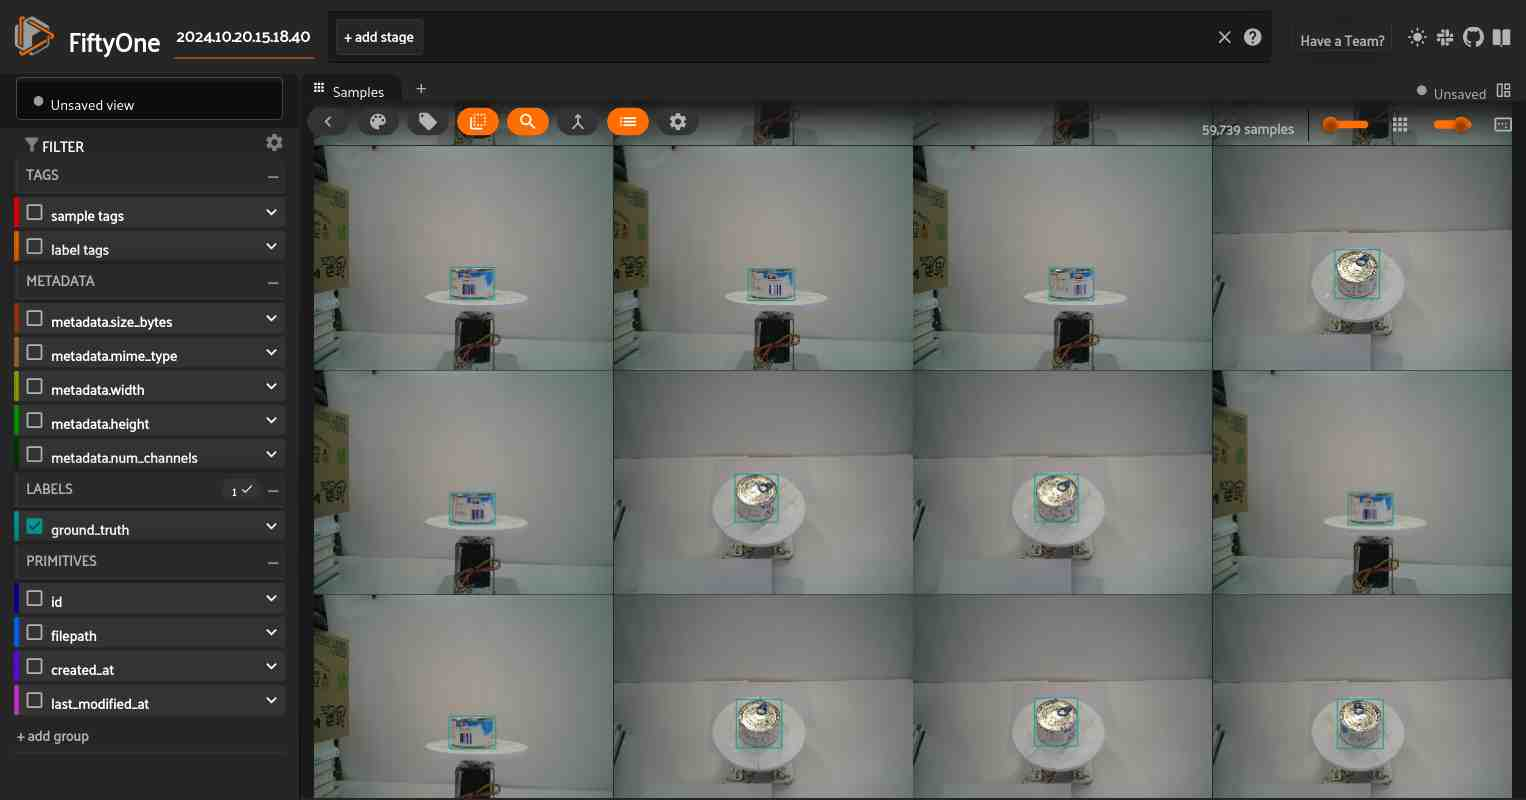

In [12]:
# Launch the FiftyOne app to visualize
session = fo.launch_app(train_dataset)

In [13]:
session.freeze()


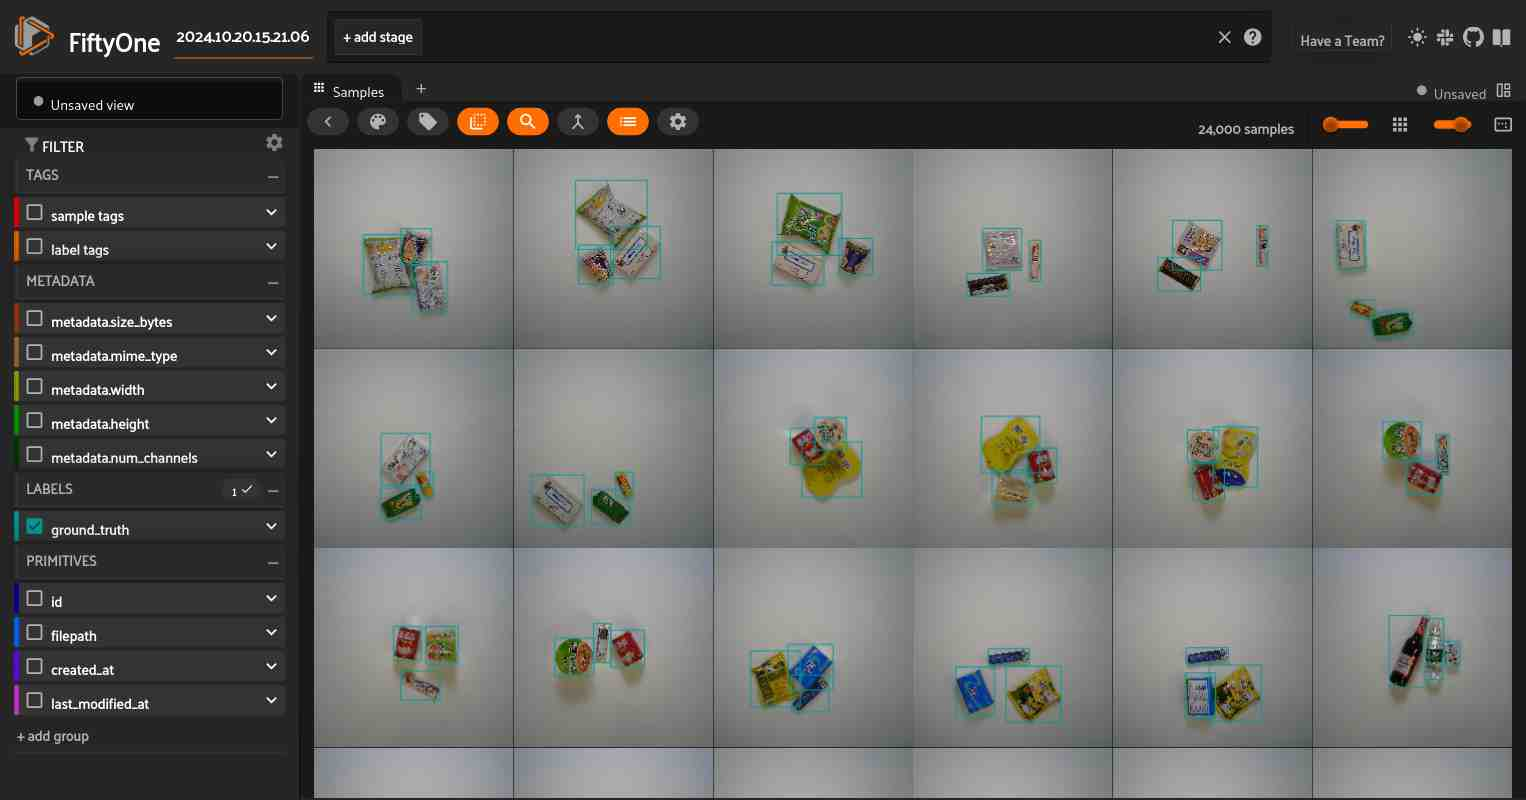

In [14]:
session = fo.launch_app(test_dataset)

In [15]:
session.freeze()

## Export Dataset To YOLO Format

To export your dataset to the YOLO format, we'll create a function that handles the conversion using FiftyOne's dataset API. This function will take your existing dataset, map the annotations to YOLO's format, and organize the data into train, validation, and test subsets.

### Define the Export Function
We'll define a function to export the dataset from FiftyOne to the YOLO format. The export will include images, annotation labels, and class names. In the following function,

1. samples: A FiftyOne dataset or sample view containing the data to be exported.

2. export_dir: The directory path where the exported YOLOv5 dataset will be saved.

3. classes: A list of class names (labels) for the object detection task.

4. label_field: The field name in the sample that contains the labels (default is "ground_truth").

5. split: Optional; specifies which subset of the dataset to export (e.g., "train", "val").

In [16]:
def export_yolo_data(
    samples,
    export_dir,
    classes,
    label_field = "ground_truth",
    split = None
    ):

    if type(split) == list:
        splits = split
        for split in splits:
            export_yolo_data(
                samples,
                export_dir,
                classes,
                label_field,
                split
            )
    else:
        if split is None:
            split_view = samples
            split = "val"
        else:
            split_view = samples.match_tags(split)

        split_view.export(
            export_dir=export_dir,
            dataset_type=fo.types.YOLOv5Dataset,
            label_field=label_field,
            classes=classes,
            split=split
        )

coco_dir = "retail_train_val"

## delete existing tags to start fresh
train_dataset.untag_samples(train_dataset.distinct("tags"))

## split into train and val
four.random_split(
    train_dataset,
    {"train": 0.8, "val": 0.2}
)

# export train and val in YOLO format
# export_yolo_data(
#     train_dataset,
#     coco_dir,
#     classes,
#     split = ["train", "val"]
# )

# # prepare test dataset in yolo format
# export_yolo_data(
#     test_dataset,
#     coco_dir,
#     classes
# )

### Review the YOLO Format

After the export, each subset will contain:

1. An images/ folder with the respective image files.

2. A labels/ folder containing .txt files where each file corresponds to an image and contains annotations.

3. A dataset.yaml file with class names and file paths for train, val and test folders.

## Fine-Tuning YOLO

In [17]:
model = YOLO("yolov8n.pt")
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [30]:
# Train the model
# train_results = model.train(
#     data= coco_dir+ "/dataset.yaml",  # path to dataset YAML
#     epochs=3,  # number of training epochs
#     imgsz=640,  # training image size
#     device="0",  
# )

New https://pypi.org/project/ultralytics/8.3.15 available  Update with 'pip install -U ultralytics'

Ultralytics 8.3.14  Python-3.10.2 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

[34m[1mengine\trainer: [0mtask=detect, mode=train, model=yolov8n.pt, data=retail_train_val/dataset.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=None, workspace=4, nms=False, lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0, label_smoothing=0.0, nbs=64, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, bgr=0.0, mosaic=1.0, mixup=0.0, copy_paste=0.0, copy_paste_mode=flip, auto_augment=randaugment, erasing=0.4, crop_fraction=1.0, cfg=None, tracker=botsort.yaml, save_dir=runs\detect\train2

Overriding model.yaml nc=80 with nc=17

|    |     from     | n | params |                module                |       arguments      |
|:--:|:------------:|:-:|:------:|:------------------------------------:|:--------------------:|
|  0 |      -1      | 1 |   464  |   ultralytics.nn.modules.conv.Conv   | [3, 16, 3, 2]        |
|  1 | -1           | 1 |  4672  |   ultralytics.nn.modules.conv.Conv   | [16, 32, 3, 2]       |
|  2 | -1           | 1 |  7360  |   ultralytics.nn.modules.block.C2f   | [32, 32, 1, True]    |
| 3  | -1           | 1 | 18560  | ultralytics.nn.modules.conv.Conv     | [32, 64, 3, 2]       |
| 4  | -1           | 2 | 49664  | ultralytics.nn.modules.block.C2f     | [64, 64, 2, True]    |
| 5  | -1           | 1 | 73984  | ultralytics.nn.modules.conv.Conv     | [64, 128, 3, 2]      |
| 6  | -1           | 2 | 197632 | ultralytics.nn.modules.block.C2f     | [128, 128, 2, True]  |
| 7  | -1           | 1 | 295424 | ultralytics.nn.modules.conv.Conv     | [128, 256, 3, 2]     |
| 8  | -1           | 1 | 460288 | ultralytics.nn.modules.block.C2f     | [256, 256, 1, True]  |
| 9  | -1           | 1 | 164608 | ultralytics.nn.modules.block.SPPF    | [256, 256, 5]        |
| 10 | -1           | 1 | 0      | torch.nn.modules.upsampling.Upsample | [None, 2, 'nearest'] |
| 11 | [-1, 6]      | 1 | 0      | ultralytics.nn.modules.conv.Concat   | [1]                  |
| 12 | -1           | 1 | 148224 | ultralytics.nn.modules.block.C2f     | [384, 128, 1]        |
| 13 | -1           | 1 | 0      | torch.nn.modules.upsampling.Upsample | [None, 2, 'nearest'] |
| 14 | [-1, 4]      | 1 | 0      | ultralytics.nn.modules.conv.Concat   | [1]                  |
| 15 | -1           | 1 | 37248  | ultralytics.nn.modules.block.C2f     | [192, 64, 1]         |
| 16 | -1           | 1 | 36992  | ultralytics.nn.modules.conv.Conv     | [64, 64, 3, 2]       |
| 17 | [-1, 12]     | 1 | 0      | ultralytics.nn.modules.conv.Concat   | [1]                  |
| 18 | -1           | 1 | 123648 | ultralytics.nn.modules.block.C2f     | [192, 128, 1]        |
| 19 | -1           | 1 | 147712 | ultralytics.nn.modules.conv.Conv     | [128, 128, 3, 2]     |
| 20 | [-1, 9]      | 1 | 0      | ultralytics.nn.modules.conv.Concat   | [1]                  |
| 21 | -1           | 1 | 493056 | ultralytics.nn.modules.block.C2f     | [384, 256, 1]        |
| 22 | [15, 18, 21] | 1 | 433987 | ultralytics.nn.modules.head.Detect   | [17, [64, 128, 256]] | 

Model summary: 249 layers, 2,693,523 parameters, 2,693,507 gradients, 7.0 GFLOPs

Transferred 313/391 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
[34m[1mAMP: [0mrunning Automatic Mixed Precision (AMP) checks with YOLO11n...
[34m[1mAMP: [0mchecks passed 

train: Scanning C:\Users\vanshika\Desktop\GitHub\voxel51\retail_train_val\labels\train... 47791 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47791/47791 [13:20<00:00, 59.68it/s] 
train: New cache created: C:\Users\vanshika\Desktop\GitHub\voxel51\retail_train_val\labels\train.cache

val: Scanning C:\Users\vanshika\Desktop\GitHub\voxel51\retail_train_val\labels\val... 11948 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11948/11948 [03:41<00:00, 54.00it/s] 

val: New cache created: C:\Users\vanshika\Desktop\GitHub\voxel51\retail_train_val\labels\val.cache
Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000476, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/3      4.71G     0.7279      2.361       1.02         72        640: 100%|██████████| 2987/2987 [18:50<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 374/374 [02:24<00:00,  2.59it/s]
                   all      11948      26460      0.742      0.743      0.805      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        2/3      2.61G     0.6407      1.056     0.9708         58        640: 100%|██████████| 2987/2987 [12:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 374/374 [02:12<00:00,  2.82it/s]
                   all      11948      26460      0.885      0.864      0.936      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        3/3      2.64G     0.5972     0.7258     0.9508         63        640: 100%|██████████| 2987/2987 [11:58<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 374/374 [02:14<00:00,  2.78it/s]
                   all      11948      26460      0.946      0.939      0.981      0.865

3 epochs completed in 0.833 hours.

Optimizer stripped from runs\detect\train2\weights\last.pt, 5.6MB

Optimizer stripped from runs\detect\train2\weights\best.pt, 5.6MB

Validating runs\detect\train2\weights\best.pt...

Ultralytics 8.3.14  Python-3.10.2 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Model summary (fused): 186 layers, 2,687,683 parameters, 0 gradients, 6.8 GFLOPs

|       Class      | Images | Instances | Box(P |   R   | mAP50 | mAP50-95) |
|:----------------:|:------:|:---------:|:-----:|:-----:|:-----:|-----------|
|        all       |  11948 | 26460     | 0.946 | 0.938 | 0.981 | 0.865     |
|      alcohol     | 748    | 1137      | 0.863 | 0.904 | 0.952 | 0.837     |
|       candy      | 962    | 1357      | 0.916 | 0.908 | 0.971 | 0.832     |
| canned_food      | 810    | 1346      | 0.97  | 0.868 | 0.979 | 0.871     |
| chocolate        | 1223   | 1779      | 0.939 | 0.984 | 0.99  | 0.849     |
| dessert          | 1609   | 2459      | 0.951 | 0.969 | 0.989 | 0.898     |
| dried_food       | 893    | 1232      | 0.927 | 0.995 | 0.992 | 0.874     |
| dried_fruit      | 959    | 1386      | 0.983 | 0.949 | 0.991 | 0.894     |
| drink            | 1030   | 1835      | 0.902 | 0.929 | 0.967 | 0.854     |
| gum              | 756    | 1115      | 0.954 | 0.96  | 0.984 | 0.812     |
| instant_drink    | 925    | 1373      | 0.933 | 0.915 | 0.971 | 0.867     |
| instant_noodles  | 1024   | 1584      | 0.907 | 0.99  | 0.991 | 0.909     |
| milk             | 773    | 1334      | 0.985 | 0.909 | 0.987 | 0.841     |
| personal_hygiene | 885    | 1291      | 0.956 | 0.926 | 0.983 | 0.865     |
| puffed_food      | 1184   | 1818      | 0.983 | 0.992 | 0.995 | 0.933     |
| seasoner         | 1096   | 1706      | 0.961 | 0.907 | 0.977 | 0.843     |
| stationery       | 703    | 932       | 0.954 | 0.863 | 0.961 | 0.803     |
| tissue           | 1928   | 2776      | 0.996 | 0.97  | 0.995 | 0.916     |

Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train2

## Training Results

![Training Results](results.png)


### F1-Confidence Curve
![F1](F1_curve.png)

Batch Predictions

![Image](val_batch0_labels.jpg)

## Run Prediction 

After fine-tuning the model on your dataset, we can run the prediction code and save the results to evaluate with FiftyOne.

In [31]:
# !yolo task=detect mode=predict model=runs/detect/train2/weights/best.pt source=retail_train_val/images/test save_txt=True save_conf=True

Ultralytics 8.3.14 🚀 Python-3.10.2 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 186 layers, 2,687,683 parameters, 0 gradients, 6.8 GFLOPs

image 1/24000 c:\Users\vanshika\Desktop\GitHub\voxel51\retail_train_val\images\test\20180824-13-35-55-2.jpg: 640x640 1 alcohol, 4 chocolates, 3 desserts, 2 drinks, 1 stationery, 21.0ms 

image 2/24000 c:\Users\vanshika\Desktop\GitHub\voxel51\retail_train_val\images\test\20180824-13-36-25-2.jpg: 640x640 1 alcohol, 1 candy, 3 chocolates, 3 desserts, 2 drinks, 1 stationery, 10.0ms
...
Speed: 6.9ms preprocess, 29.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

Results saved to runs\detect\predict2

24000 labels saved to runs\detect\predict2\labels


once you have a trained model and predictions ready, we can integrate that with fiftyone to visualize the results

In [19]:
def get_prediction_filepath(filepath, run_number = 2):
    run_num_string = ""
    if run_number != 1:
        run_num_string = str(run_number)
    filename = filepath.split("/")[-1].split(".")[0]
    return f"runs/detect/predict{run_num_string}/labels/{filename}.txt"

# extract the filepaths from prediction folder
filepaths = test_dataset.values("filepath")
prediction_filepaths = [get_prediction_filepath(fp) for fp in filepaths]

# save it to the fiftyone dataset as another field with predictions
test_dataset.set_values(
    "yolov8n_det_filepath",
    prediction_filepaths
)

In [20]:
def read_yolo_detections_file(filepath):
    detections = []
    if not os.path.exists(filepath):
        return np.array([])

    with open(filepath) as f:
        lines = [line.rstrip('\n').split(' ') for line in f]

    for line in lines:
        detection = [float(l) for l in line]
        detections.append(detection)
    return np.array(detections)

def _uncenter_boxes(boxes):
    '''convert from center coords to corner coords'''
    boxes[:, 0] -= boxes[:, 2]/2.
    boxes[:, 1] -= boxes[:, 3]/2.

def _get_class_labels(predicted_classes, class_list):
    labels = (predicted_classes).astype(int)
    labels = [class_list[l] for l in labels]
    return labels

def convert_yolo_detections_to_fiftyone(
    yolo_detections,
    class_list
    ):

    detections = []
    if yolo_detections.size == 0:
        return fo.Detections(detections=detections)

    boxes = yolo_detections[:, 1:-1]
    _uncenter_boxes(boxes)

    confs = yolo_detections[:, -1]
    labels = _get_class_labels(yolo_detections[:, 0], class_list)

    for label, conf, box in zip(labels, confs, boxes):
        detections.append(
            fo.Detection(
                label=label,
                bounding_box=box.tolist(),
                confidence=conf
            )
        )

    return fo.Detections(detections=detections)

def add_yolo_detections(
    samples,
    prediction_field,
    prediction_filepath,
    class_list
    ):

    prediction_filepaths = samples.values(prediction_filepath)
    yolo_detections = [read_yolo_detections_file(pf) for pf in prediction_filepaths]
    detections =  [convert_yolo_detections_to_fiftyone(yd, class_list) for yd in yolo_detections]
    samples.set_values(prediction_field, detections)

In [21]:
# now combine the detections with the dataset by adding another field to it
# this will run for 5-6 minutes or so
add_yolo_detections(
    test_dataset,
    "yolov8n",
    "yolov8n_det_filepath",
    classes
)

In the following example, you can see the objects are correctly identified with a confidence of 94% and above.


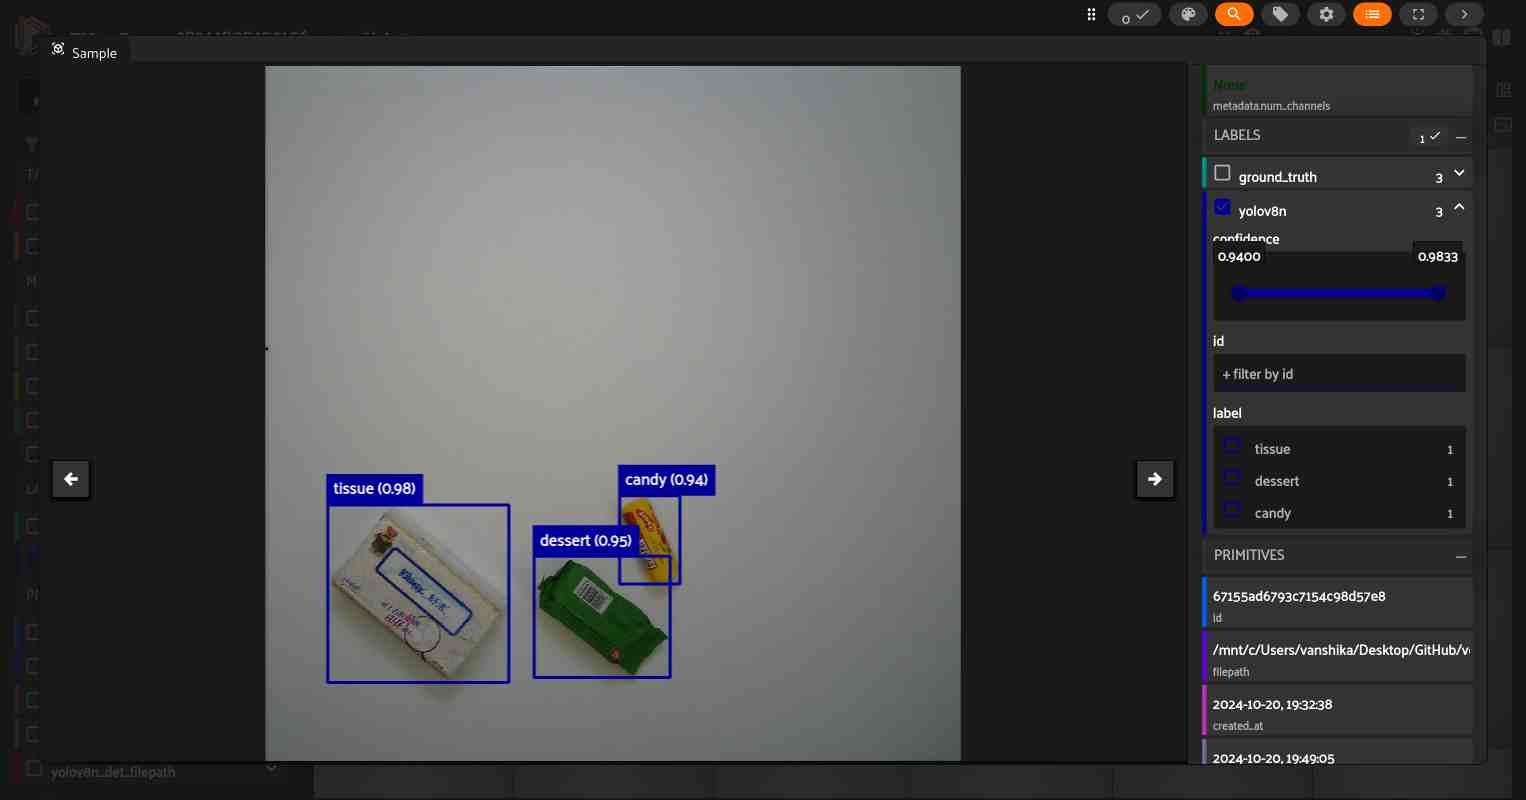

In [22]:
session = fo.launch_app(test_dataset)

In [23]:
session.freeze()

## Evaluate Detections

The evaluate_detections function in FiftyOne compares the predicted detections (stored in the field `yolov8n`) to the ground-truth labels (stored in `ground_truth`) in the test dataset. It calculates performance metrics for object detection, including the mean Average Precision (mAP), which is a standard metric to evaluate how well the model predicts objects.

- gt_field: The ground truth labels (actual object locations).

- pred_field: The predicted object detections (YOLOv8 outputs).

- eval_key: Stores the evaluation results in the dataset under this key (eval).

- classes: List of object categories being evaluated.

- compute_mAP: Set to True to calculate the mAP score.

In [24]:
# this will take around 20 mins so sit back and relax
detection_results = test_dataset.evaluate_detections(
    gt_field="ground_truth",
    pred_field="yolov8n",
    eval_key="eval",
    classes=classes,
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████| 24000/24000 [12.3m elapsed, 0s remaining, 13.4 samples/s]      
Performing IoU sweep...
 100% |█████████████| 24000/24000 [11.2m elapsed, 0s remaining, 24.9 samples/s]      


In [35]:
detection_results.mAP() * 100

79.05457078859357

### Top 10 Classes 

In [25]:
counts = test_dataset.count_values("ground_truth.detections.label")

top10_classes = sorted(
    counts,
    key=counts.get,
    reverse=True
)[:10]

detection_results.print_report(classes=top10_classes)

                 precision    recall  f1-score   support

         tissue       0.99      0.98      0.98     27439
        dessert       0.84      0.97      0.90     25001
          drink       0.77      0.95      0.85     23946
    puffed_food       0.97      0.99      0.98     19056
       seasoner       0.85      0.96      0.90     19042
      chocolate       0.83      0.98      0.90     18992
instant_noodles       0.85      0.99      0.92     18020
    canned_food       0.91      0.93      0.92     17707
           milk       0.89      0.95      0.92     16332
        alcohol       0.73      0.95      0.83     15975

      micro avg       0.86      0.97      0.91    201510
      macro avg       0.86      0.96      0.91    201510
   weighted avg       0.87      0.97      0.91    201510



### The Top Class of Test Dataset - Tissue


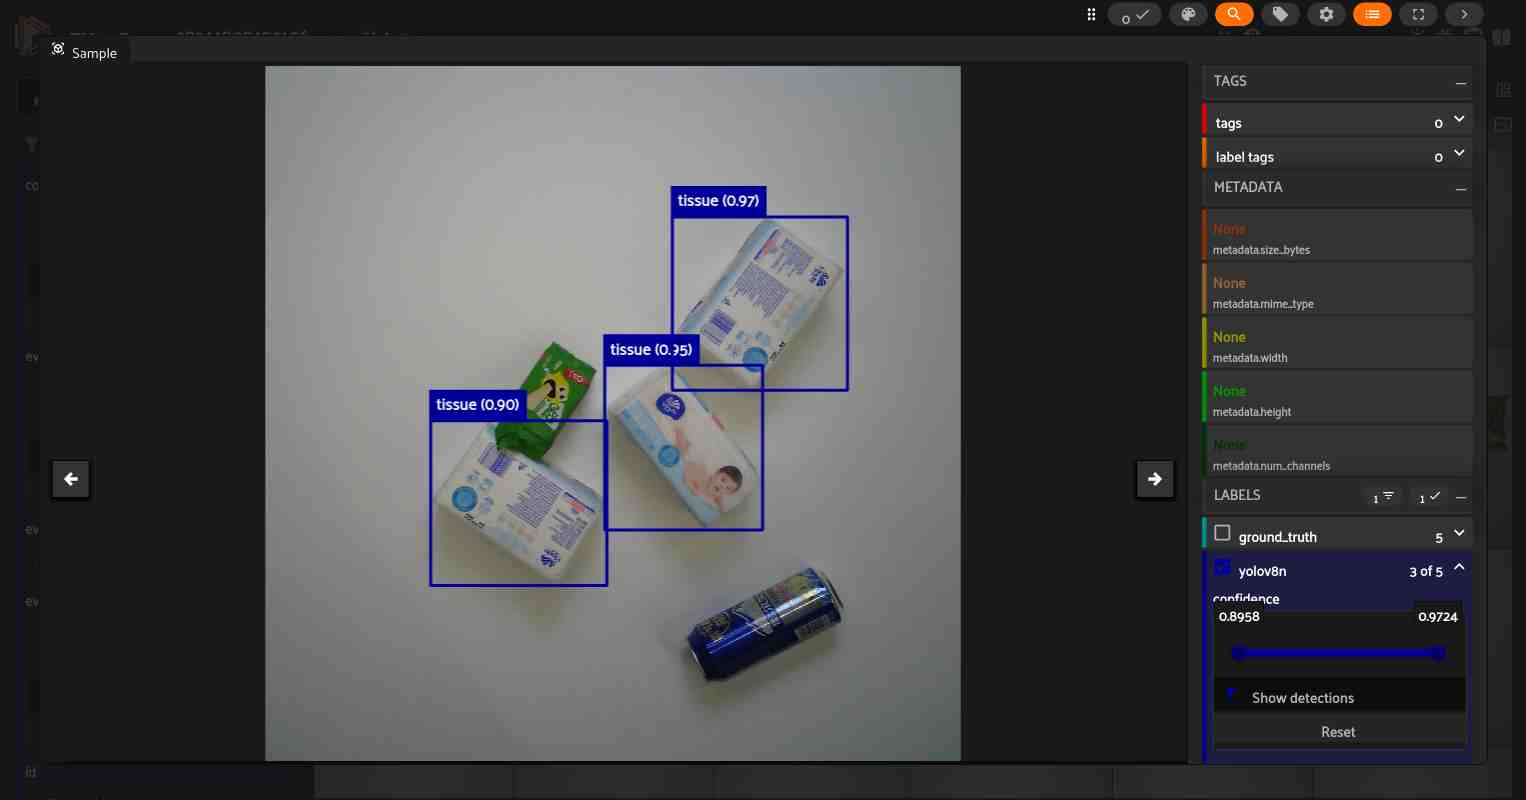

In [9]:
session = fo.launch_app(test_dataset)

In [10]:
session.freeze()

## Find uniqueness in Test Data

Now we can process the entire dataset for uniqueness. This is a fairly expensive operation, but should finish in a few minutes at most. We are processing through all samples in the dataset, then building a representation that relates the samples to each other. Finally, we analyze this representation to output uniqueness scores for each sample.

In [11]:
fob.compute_uniqueness(test_dataset)


 100% |████|  100.6Mb/100.6Mb [800.6ms elapsed, 0s remaining, 125.6Mb/s]      
Computing embeddings...
 100% |█████████████| 24000/24000 [3.7m elapsed, 0s remaining, 120.1 samples/s]      
Computing uniqueness...
Computing neighbors for 24000 embeddings; this may take awhile...
Uniqueness computation complete


### Visualize to find duplicate and near-duplicate images

When we sort the whole dataset by `uniqueness` field, we get a number that identifies how unique this sample is.


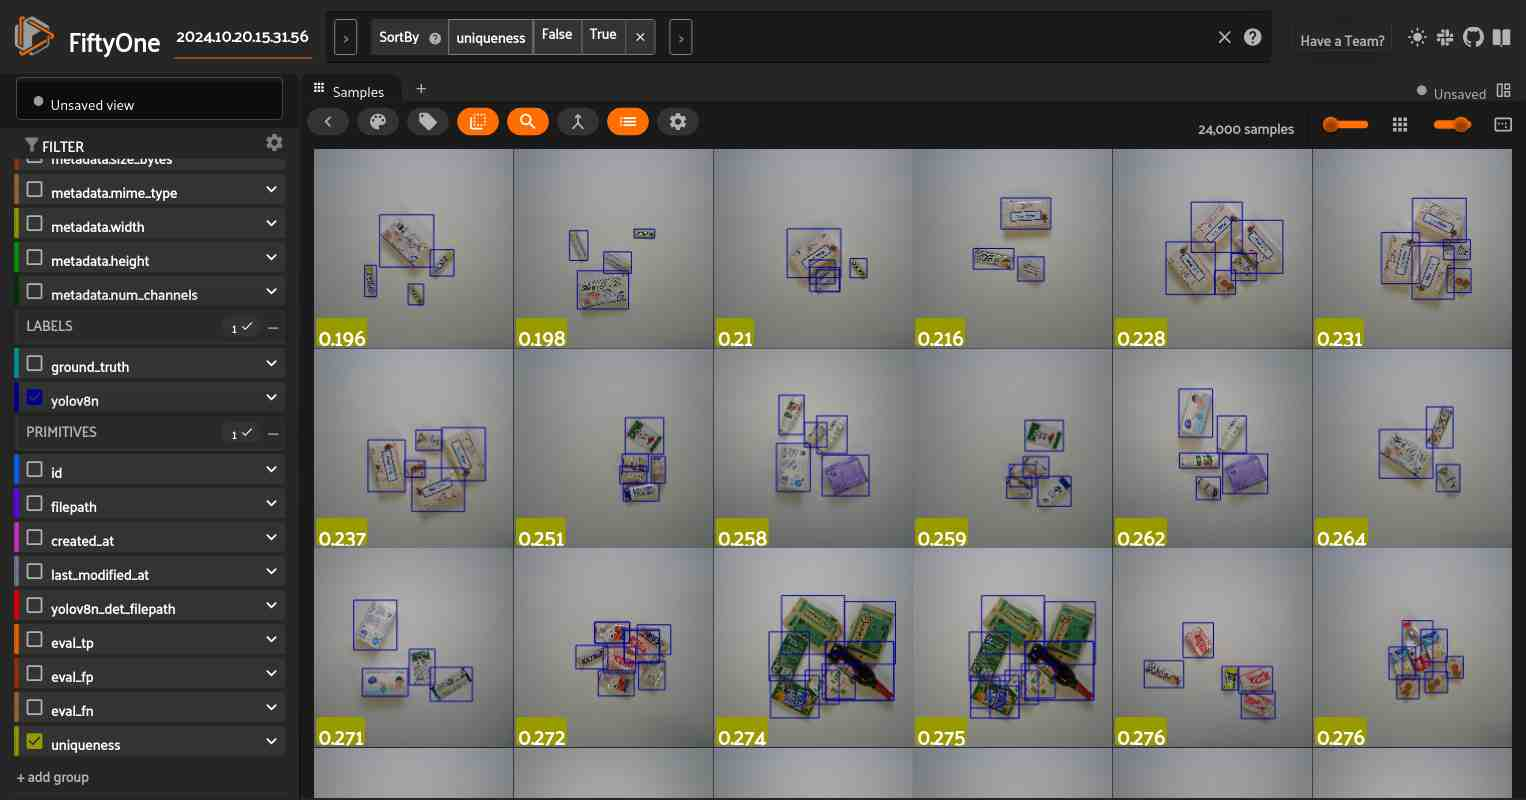

In [15]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = test_dataset.sort_by("uniqueness")

# Open view in the App
session.view = dups_view

In [16]:
session.freeze()

## Conclusion

While YOLOv8 represents a significant leap forward in real-time object detection, it’s initially designed for general-purpose use. Before deploying the model on specialized datasets like the Retail Product Checkout (RPC) dataset, it's crucial to thoroughly evaluate how well it performs on your specific data. This ensures you can fine-tune the YOLOv8 architecture to meet your precise needs.

With FiftyOne, you can not only visualize and analyze YOLOv8 predictions but also gain deeper insights into the model’s behavior on the RPC dataset. In doing so, you can ensure that your detection model is tailored and ready for real-world challenges, where precision and adaptability are key to success.